# Exploring MobileNet and comparing it to normal CNN using Weather Classification Dataset

#### Basic Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#### Creating Img Generators

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_dir = "/Users/aadityajoshi/Downloads/dataset-2/train"

In [195]:
# adding various augmentation parameters to ImageDatagen object
# this will change every image randomly while loading making the model more robust
img_datagen = ImageDataGenerator(validation_split = 0.2,
                                rescale =  1/255.,
                                horizontal_flip = True)

In [196]:
# MobileNet v1 uses 224x224x3 size in the reasearach paper, we'll be using the same
#mention only hxw in imagegen object
train_generator = img_datagen.flow_from_directory(train_dir,
                                            target_size=(224,224),
                                            batch_size = 32,
                                            class_mode='categorical',
                                            subset='training')

Found 1200 images belonging to 5 classes.


In [197]:
#preparing validation or dev data
val_generator = img_datagen.flow_from_directory(train_dir,
                                            target_size=(224,224),
                                            batch_size = 32,
                                            class_mode='categorical',
                                            subset='validation')

Found 300 images belonging to 5 classes.


In [25]:
train_generator.class_indices

{'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}

In [40]:
train_generator.image_shape

(224, 224, 3)

### Sample images

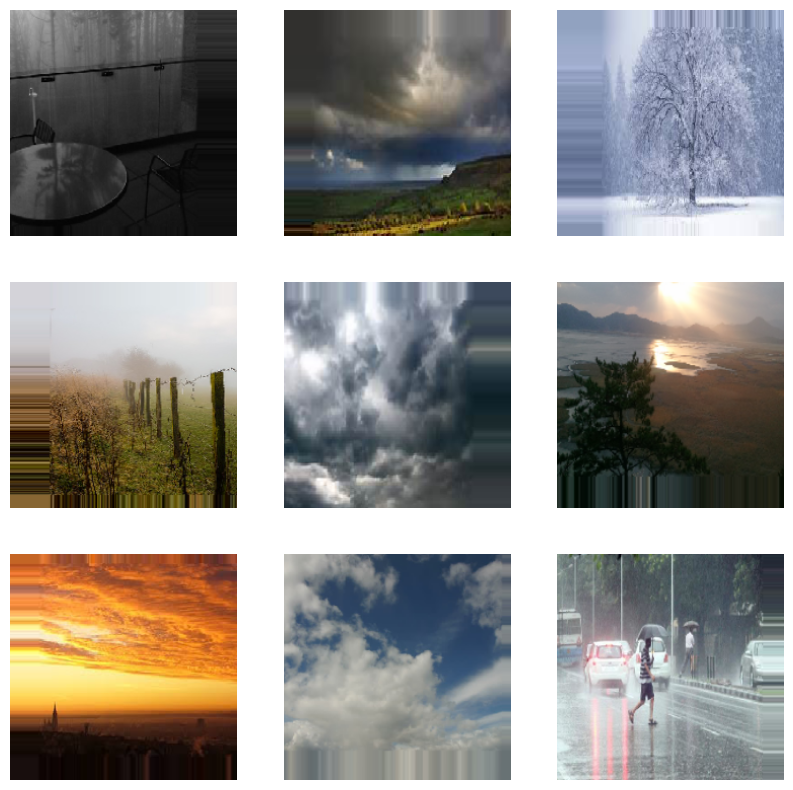

In [57]:
def show_batch_of_images(dataset):
    images, labels = next(dataset)  # Get a batch of images and labels
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.show()
show_batch_of_images(train_generator)

In [53]:
from pathlib import Path
def count_classes(dataset, class_name):
    dataset_path = Path(dataset)  # Convert to Path object
    class_path = dataset_path / class_name
    return len(list(class_path.glob('*'))) 

def create_class_counts_df(dataset, class_names):
    counts = {'class':[], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

In [51]:
class_names = ['cloudy', 'foggy','rainy','shine','sunrise']

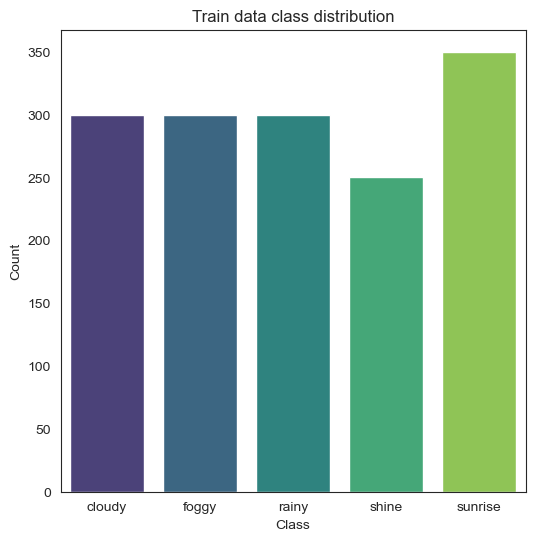

In [113]:
#almost equal distribution of all classes
train_df = create_class_counts_df(train_dir,class_names)
sns.set_style("white")
plt.figure(figsize=(6,6))
plot_class_distribution(train_df,"Train data class distribution")

### Creating Models

In [58]:
num_classes = len(class_names)

### Exploring 3 architechtures LeNet-5, MobileNet, Custom_CNN

#### LeNet 5

In [59]:
#instead of using Average Pooling using MaxPooling Layers along with relu activation function instead of tanh
# by changing tanh -> relu, observed increase in accuracy

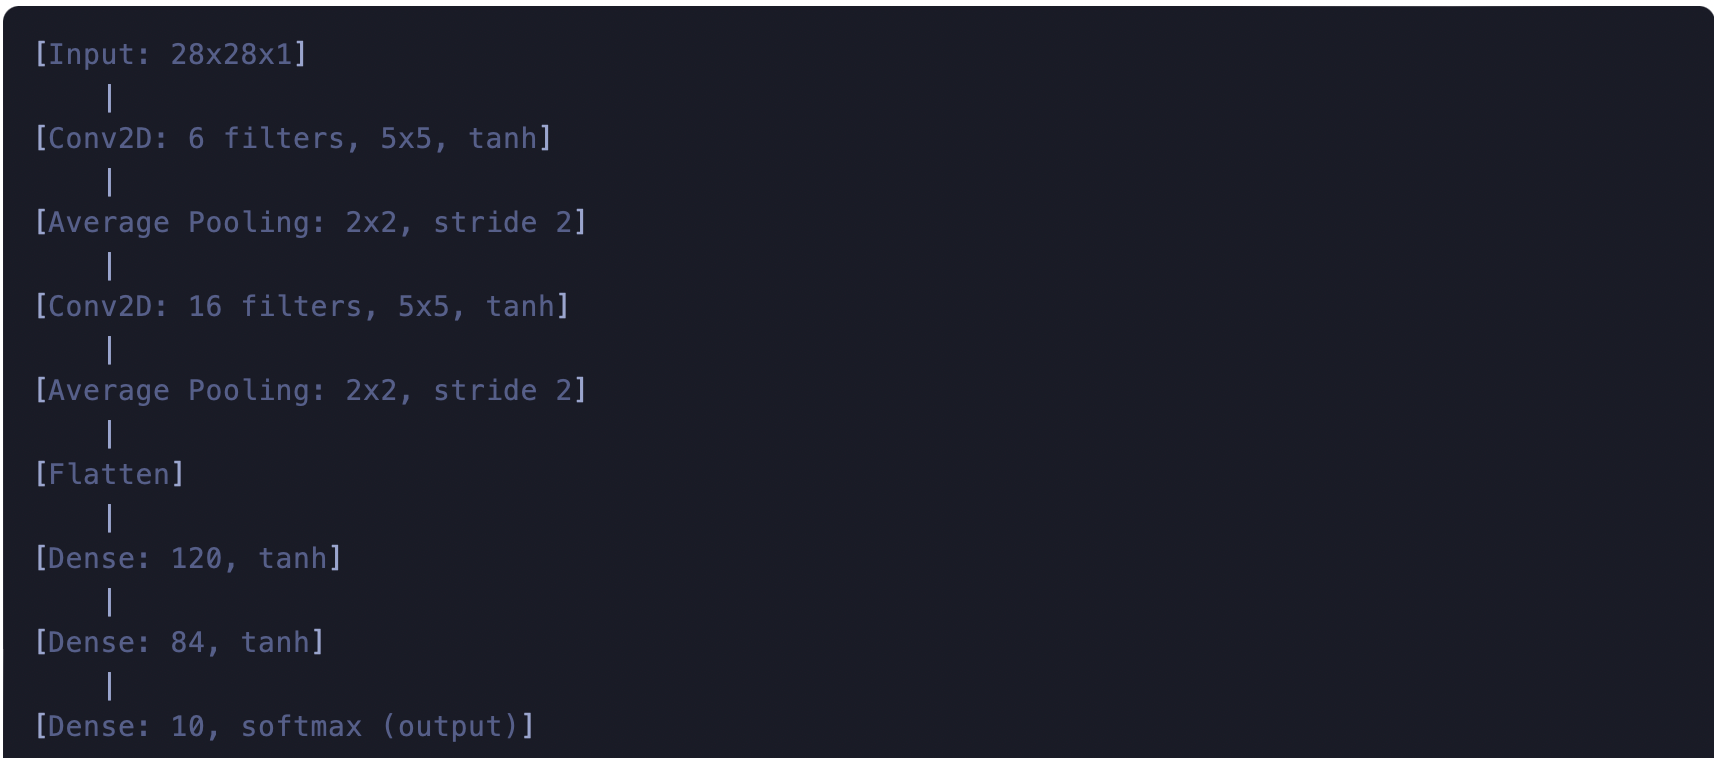

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Flatten,Dense,Dropout

In [77]:
def create_model_LeNet():
    # create Sequential object
    model = Sequential()
    # Input layer
    model.add(Input(shape=(224,224,3)))
    # First Convolution layer 6 filters of size 5,5
    model.add(Conv2D(filters=6,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'))
    # MaxPool layer with stride 2
    model.add(MaxPooling2D(2,2))
    # Second Convolution layer
    model.add(Conv2D(filters=16,kernel_size=(5,5),strides=(1,1),padding='valid',activation='relu'))
    # 2nd Maxpooling layer
    model.add(MaxPooling2D(2,2))
    # Flatten
    model.add(Flatten())
    # FC Layer 1 -> 120
    model.add(Dense(120,activation='relu'))
    model.add(Dropout(0.1))
    # FC Layer 2 ->84
    model.add(Dense(84,activation='relu'))
    model.add(Dropout(0.1))
    # Output layer
    model.add(Dense(5,activation='relu'))
    
    #compiling
    model.compile(loss='categorical_crossentropy',optimizer = 'adam', metrics=['accuracy'])
    
    #summary
    model.summary()
    return model
    

In [214]:
from tensorflow.keras.backend import clear_session
clear_session()
Lenet_5 = create_model_LeNet()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     5,393,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           425 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,406,861 (20.63 MB)

 Trainable params: 5,406,861 (20.63 MB)

 Non-trainable params: 0 (0.00 B)

In [200]:
#training model
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):    
    Lenet_5.fit(train_generator,
                validation_data=val_generator,
                steps_per_epoch=train_generator.samples//train_generator.batch_size,
                validation_steps= val_generator.samples//val_generator.batch_size,
               epochs =100)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.2164 - loss: 2.2433 - val_accuracy: 0.5764 - val_loss: 1.4694
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.9140 - val_accuracy: 0.7500 - val_loss: 1.3046
Epoch 3/100


2024-07-28 15:23:32.146443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:32.146458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:23:32.146466: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:23:32.146468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_50]]
2024-07-28 15:23:32.146485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:23:32.146496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 107677789

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.4264 - loss: 1.3784 - val_accuracy: 0.4028 - val_loss: 1.1349
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.3125 - loss: 1.2601 - val_accuracy: 0.3333 - val_loss: 1.5017
Epoch 5/100


2024-07-28 15:23:37.225503: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:37.225524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_18/_40]]
2024-07-28 15:23:37.225540: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:23:37.225543: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:23:37.225546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:23:37.225551: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 143047822

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.4437 - loss: 1.3192 - val_accuracy: 0.6806 - val_loss: 1.1005
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - accuracy: 0.5625 - loss: 0.8926 - val_accuracy: 0.5000 - val_loss: 1.0045
Epoch 7/100


2024-07-28 15:23:42.007465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:42.007477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:23:42.007482: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:23:42.007485: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:23:42.007488: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:23:42.007490: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.6108 - loss: 1.2325 - val_accuracy: 0.6597 - val_loss: 1.2429
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.6875 - loss: 0.7584 - val_accuracy: 0.7500 - val_loss: 0.5111
Epoch 9/100


2024-07-28 15:23:46.632406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:46.632420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:23:46.632425: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:23:46.632429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:23:46.632434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_54]]
2024-07-28 15:23:46.632448: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 158063401

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5336 - loss: 1.3852 - val_accuracy: 0.4271 - val_loss: 1.1777
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.5625 - loss: 1.2110 - val_accuracy: 0.5000 - val_loss: 1.0444
Epoch 11/100


2024-07-28 15:23:51.253648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:51.253663: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:23:51.253667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:23:51.253672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp_1/_23]]
2024-07-28 15:23:51.253687: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:23:51.253693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item 

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.5542 - loss: 1.2069 - val_accuracy: 0.5382 - val_loss: 1.1633
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - accuracy: 0.4062 - loss: 1.5973 - val_accuracy: 0.7500 - val_loss: 0.8442
Epoch 13/100


2024-07-28 15:23:55.977079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:23:55.977093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:23:55.977098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_46]]
2024-07-28 15:23:55.977108: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:23:55.977113: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:23:55.977122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5619 - loss: 1.3677 - val_accuracy: 0.5556 - val_loss: 1.0089
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step - accuracy: 0.6250 - loss: 0.9149 - val_accuracy: 0.5833 - val_loss: 0.9225
Epoch 15/100


2024-07-28 15:24:00.568294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:00.568307: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:24:00.568313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_74]]
2024-07-28 15:24:00.568321: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:24:00.568331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:24:00.568342: I tensorflow/core/framewo

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5981 - loss: 1.0488 - val_accuracy: 0.5104 - val_loss: 1.1231
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.5625 - loss: 1.3725 - val_accuracy: 0.5833 - val_loss: 1.2470
Epoch 17/100


2024-07-28 15:24:05.162315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:05.162330: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/categorical_crossentropy/mul/Shape/_92]]
2024-07-28 15:24:05.162347: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:24:05.162357: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:24:05.162367: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:24:05.162374: I tensorflow/core/framework/local_rendezvous.cc:422] Local r

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.5545 - loss: 1.1198 - val_accuracy: 0.6840 - val_loss: 0.9632
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.6875 - loss: 0.7825 - val_accuracy: 0.8333 - val_loss: 0.7098
Epoch 19/100


2024-07-28 15:24:09.719056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:09.719071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:24:09.719075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:24:09.719079: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:24:09.719084: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:24:09.719088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12797271424742821364
2024-07-28 15:24:09.719090: W tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.6685 - loss: 1.0590 - val_accuracy: 0.6597 - val_loss: 1.0004
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.7188 - loss: 0.7637 - val_accuracy: 0.6667 - val_loss: 0.8318
Epoch 21/100


2024-07-28 15:24:14.336173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:14.336183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_74]]
2024-07-28 15:24:14.336200: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:24:14.336205: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:24:14.336212: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5042100060331345279
2024-07-28 15:24:14.336215: I tensorflow/core/framewo

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.4960 - loss: 1.2373 - val_accuracy: 0.5104 - val_loss: 1.3109
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.4375 - loss: 1.2724 - val_accuracy: 0.5000 - val_loss: 1.5083
Epoch 23/100


2024-07-28 15:24:18.902347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:18.902363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:24:18.902367: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:24:18.902369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp/_25]]
2024-07-28 15:24:18.902382: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:18.902385: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item ca

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.5661 - loss: 1.2176 - val_accuracy: 0.2431 - val_loss: 3.7390
Epoch 24/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.2812 - loss: 3.9775 - val_accuracy: 0.4167 - val_loss: 1.2152
Epoch 25/100


2024-07-28 15:24:23.509378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:23.509398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:24:23.509405: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:23.509412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:23.509414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:23.509416: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.3647 - loss: 2.2533 - val_accuracy: 0.6215 - val_loss: 1.2386
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.4688 - loss: 1.1998 - val_accuracy: 0.9167 - val_loss: 0.8354
Epoch 27/100


2024-07-28 15:24:28.118243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:28.118255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp_1/_23]]
2024-07-28 15:24:28.118265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:28.118270: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:28.118272: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:28.118276: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6195 - loss: 1.1720 - val_accuracy: 0.6910 - val_loss: 1.0656
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7500 - loss: 0.6836 - val_accuracy: 0.7500 - val_loss: 0.7414
Epoch 29/100


2024-07-28 15:24:32.648690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:32.648703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:24:32.648722: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:32.648728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:32.648731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:32.648733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.6657 - loss: 1.0801 - val_accuracy: 0.2396 - val_loss: 3.1124
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - accuracy: 0.2812 - loss: 3.3301 - val_accuracy: 0.2500 - val_loss: 2.5797
Epoch 31/100


2024-07-28 15:24:37.404263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:37.404279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_6/_44]]
2024-07-28 15:24:37.404291: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:24:37.404300: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:24:37.404305: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:24:37.404308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 310184966

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.3126 - loss: 1.9653 - val_accuracy: 0.4097 - val_loss: 1.2742
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.4375 - loss: 1.2156 - val_accuracy: 0.5000 - val_loss: 1.2203
Epoch 33/100


2024-07-28 15:24:42.148298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:42.148313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_52]]
2024-07-28 15:24:42.148324: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:24:42.148333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:24:42.148335: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:24:42.148345: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 176490828

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.3917 - loss: 1.2630 - val_accuracy: 0.4062 - val_loss: 1.1698
Epoch 34/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4062 - loss: 1.2941 - val_accuracy: 0.4167 - val_loss: 1.0752
Epoch 35/100


2024-07-28 15:24:46.835588: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:46.835599: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:24:46.835603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:46.835606: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:46.835608: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:46.835610: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.4625 - loss: 1.1257 - val_accuracy: 0.6424 - val_loss: 1.1986
Epoch 36/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - accuracy: 0.5000 - loss: 1.0140 - val_accuracy: 0.4167 - val_loss: 2.3489
Epoch 37/100


2024-07-28 15:24:51.597985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:51.597999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/ReadVariableOp_1/_27]]
2024-07-28 15:24:51.598010: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:51.598013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:51.598015: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:51.598018: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item c

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.4818 - loss: 1.1984 - val_accuracy: 0.5799 - val_loss: 1.2950
Epoch 38/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - accuracy: 0.5938 - loss: 1.0432 - val_accuracy: 0.5833 - val_loss: 1.0384
Epoch 39/100


2024-07-28 15:24:56.318307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:24:56.318318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:24:56.318322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:24:56.318326: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:24:56.318329: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:24:56.318331: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.5288 - loss: 1.2784 - val_accuracy: 0.6944 - val_loss: 1.2762
Epoch 40/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.5625 - loss: 0.8242 - val_accuracy: 0.6667 - val_loss: 1.9524
Epoch 41/100


2024-07-28 15:25:00.952709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:00.952723: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:00.952727: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:00.952731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:25:00.952734: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 177097800014067304
2024-07-28 15:25:00.952737: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:25:00.952740: I tensorflow/core/framework/local_rendezvo

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5791 - loss: 1.1780 - val_accuracy: 0.5625 - val_loss: 1.3065
Epoch 42/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.6875 - loss: 0.9207 - val_accuracy: 0.7500 - val_loss: 0.9770
Epoch 43/100


2024-07-28 15:25:05.619791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:05.619807: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:05.619812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:05.619814: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:25:05.619816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_20/_38]]
2024-07-28 15:25:05.619827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 854047519

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.6018 - loss: 1.0449 - val_accuracy: 0.6597 - val_loss: 1.1947
Epoch 44/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.5938 - loss: 1.1598 - val_accuracy: 0.6667 - val_loss: 0.8157
Epoch 45/100


2024-07-28 15:25:10.142838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:10.142852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/add/_62]]
2024-07-28 15:25:10.142864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:10.142869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:25:10.142876: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:25:10.142879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key 

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.5840 - loss: 1.1626 - val_accuracy: 0.1771 - val_loss: 1.8525
Epoch 46/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - accuracy: 0.2188 - loss: 1.8311 - val_accuracy: 0.2500 - val_loss: 1.7819
Epoch 47/100


2024-07-28 15:25:14.710654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:14.710667: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:14.710672: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:14.710677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:25:14.710681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_54]]
2024-07-28 15:25:14.710690: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 158063401

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.1930 - loss: 1.6968 - val_accuracy: 0.2465 - val_loss: 1.5108
Epoch 48/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.3750 - loss: 1.4255 - val_accuracy: 0.2500 - val_loss: 1.4402
Epoch 49/100


2024-07-28 15:25:19.279214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:19.279226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_8/_46]]
2024-07-28 15:25:19.279233: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:19.279241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:19.279247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5042100060331345279
2024-07-28 15:25:19.279253: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 63269883704

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.3314 - loss: 1.4261 - val_accuracy: 0.5069 - val_loss: 1.2570
Epoch 50/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.5312 - loss: 1.4010 - val_accuracy: 0.3333 - val_loss: 1.3814
Epoch 51/100


2024-07-28 15:25:24.030054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:24.030069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp/_25]]
2024-07-28 15:25:24.030080: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:25:24.030088: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:25:24.030090: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:25:24.030093: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item c

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.5132 - loss: 1.2372 - val_accuracy: 0.2535 - val_loss: 1.4873
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.1562 - loss: 1.4003 - val_accuracy: 0.2500 - val_loss: 1.4396
Epoch 53/100


2024-07-28 15:25:28.668953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:28.668965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_16/_54]]
2024-07-28 15:25:28.668974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:28.668985: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:28.668990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:25:28.668993: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 158063401

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3478 - loss: 1.3185 - val_accuracy: 0.5799 - val_loss: 1.1801
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.5938 - loss: 1.1767 - val_accuracy: 0.4167 - val_loss: 1.4221
Epoch 55/100


2024-07-28 15:25:33.384196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:33.384214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_58]]
2024-07-28 15:25:33.384225: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:33.384230: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:25:33.384232: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:25:33.384245: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1545409919

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5692 - loss: 1.1591 - val_accuracy: 0.6806 - val_loss: 1.1701
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - accuracy: 0.6250 - loss: 1.4269 - val_accuracy: 0.6667 - val_loss: 0.9749
Epoch 57/100


2024-07-28 15:25:38.010701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:38.010719: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp_1/_23]]
2024-07-28 15:25:38.010729: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:25:38.010731: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:25:38.010738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:25:38.010740: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item 

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6453 - loss: 1.0434 - val_accuracy: 0.5556 - val_loss: 1.2340
Epoch 58/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - accuracy: 0.6562 - loss: 0.9149 - val_accuracy: 0.5833 - val_loss: 1.1096
Epoch 59/100


2024-07-28 15:25:42.697279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:42.697292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_14/_52]]
2024-07-28 15:25:42.697304: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:42.697308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:42.697317: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:42.697322: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 141991043

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5707 - loss: 1.0297 - val_accuracy: 0.7188 - val_loss: 1.0591
Epoch 60/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.7188 - loss: 0.9129 - val_accuracy: 0.6667 - val_loss: 1.0151
Epoch 61/100


2024-07-28 15:25:47.351829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:47.351842: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:47.351846: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_20/_38]]
2024-07-28 15:25:47.351856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:25:47.351865: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:47.351877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 141991043

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.6411 - loss: 1.0246 - val_accuracy: 0.6806 - val_loss: 1.0742
Epoch 62/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6562 - loss: 0.8092 - val_accuracy: 0.6667 - val_loss: 1.2592
Epoch 63/100


2024-07-28 15:25:51.915772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:51.915808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp/_25]]
2024-07-28 15:25:51.915821: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:25:51.915824: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:25:51.915827: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:25:51.915829: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item c

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6632 - loss: 1.1196 - val_accuracy: 0.7257 - val_loss: 1.0116
Epoch 64/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step - accuracy: 0.6875 - loss: 0.8612 - val_accuracy: 0.5833 - val_loss: 0.9353
Epoch 65/100


2024-07-28 15:25:56.618847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:25:56.618859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:25:56.618869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:25:56.618874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:25:56.618877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:25:56.618885: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5042100060331345279
2024-07-2

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6349 - loss: 0.9157 - val_accuracy: 0.6597 - val_loss: 1.1404
Epoch 66/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.3468 - val_accuracy: 0.6667 - val_loss: 0.9793
Epoch 67/100


2024-07-28 15:26:01.177897: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:01.177961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:01.177973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:01.177976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:26:01.177978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12797271424742821364
2024-07-28 15:26:01.177981: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:26:01.177983: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.6653 - loss: 1.1019 - val_accuracy: 0.6701 - val_loss: 1.1026
Epoch 68/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.6250 - loss: 0.7425 - val_accuracy: 0.5000 - val_loss: 2.1076
Epoch 69/100


2024-07-28 15:26:05.990961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_12/_50]]
2024-07-28 15:26:05.990976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:05.990986: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:05.990994: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:26:05.990996: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:05.991002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 31018496

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.5751 - loss: 1.2273 - val_accuracy: 0.5208 - val_loss: 1.0816
Epoch 70/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - accuracy: 0.5938 - loss: 0.9972 - val_accuracy: 0.4167 - val_loss: 1.0693
Epoch 71/100


2024-07-28 15:26:10.758195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_18/_40]]
2024-07-28 15:26:10.758209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:10.758215: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:10.758219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:10.758229: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:26:10.758241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 143047822

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.4777 - loss: 1.1295 - val_accuracy: 0.3576 - val_loss: 1.2363
Epoch 72/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.4375 - loss: 1.1872 - val_accuracy: 0.4167 - val_loss: 1.1985
Epoch 73/100


2024-07-28 15:26:15.380801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:15.380816: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/categorical_crossentropy/mul/Shape/_92]]
2024-07-28 15:26:15.380834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:15.380837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5738273042164436563
2024-07-28 15:26:15.380841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:26:15.380843: I tensorflow/core/framework/local_rendezvous.cc:422] Local r

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.4861 - loss: 1.1158 - val_accuracy: 0.5347 - val_loss: 1.0455
Epoch 74/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - accuracy: 0.6562 - loss: 0.9927 - val_accuracy: 0.4167 - val_loss: 1.2194
Epoch 75/100


2024-07-28 15:26:20.259998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:20.260013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:26:20.260020: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:26:20.260024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:26:20.260028: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15806340125438424508
2024-07-28 15:26:20.260032: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:20.260034: W tensorflow/core/framework/local_rendezv

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.5368 - loss: 1.1428 - val_accuracy: 0.3056 - val_loss: 1.3971
Epoch 76/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step - accuracy: 0.2812 - loss: 1.3628 - val_accuracy: 0.2500 - val_loss: 1.3788
Epoch 77/100


2024-07-28 15:26:24.979854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:24.979870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:24.979874: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:24.979877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:26:24.979879: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12797271424742821364
2024-07-28 15:26:24.979886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:26:24.979888: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.3229 - loss: 1.3714 - val_accuracy: 0.3438 - val_loss: 1.2272
Epoch 78/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.3438 - loss: 1.2848 - val_accuracy: 0.5000 - val_loss: 1.0618
Epoch 79/100


2024-07-28 15:26:29.664581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:29.664592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:26:29.664613: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:26:29.664621: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:26:29.664623: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6267016073626210140
2024-07-28 15:26:29.664630: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6326988370475517249
2024-07-2

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.3879 - loss: 1.1938 - val_accuracy: 0.5799 - val_loss: 1.0994
Epoch 80/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - accuracy: 0.4688 - loss: 1.2240 - val_accuracy: 0.6667 - val_loss: 1.0484
Epoch 81/100


2024-07-28 15:26:34.474813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:34.474824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:26:34.474830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:26:34.474834: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:26:34.474837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:26:34.474840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5787 - loss: 1.0836 - val_accuracy: 0.6736 - val_loss: 1.0514
Epoch 82/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.5000 - loss: 1.1324 - val_accuracy: 0.5833 - val_loss: 0.9384
Epoch 83/100


2024-07-28 15:26:39.043448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_48]]
2024-07-28 15:26:39.043462: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:39.043469: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:39.043474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:39.043484: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:26:39.043493: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 517994554

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5394 - loss: 1.1106 - val_accuracy: 0.3333 - val_loss: 1.3827
Epoch 84/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1875 - loss: 1.5964 - val_accuracy: 0.3333 - val_loss: 1.3301
Epoch 85/100


2024-07-28 15:26:43.630888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:43.630899: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_35]]
2024-07-28 15:26:43.630905: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:26:43.630908: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:26:43.630910: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:26:43.630914: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.3464 - loss: 1.3840 - val_accuracy: 0.4271 - val_loss: 1.2983
Epoch 86/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.4375 - loss: 1.2088 - val_accuracy: 0.5833 - val_loss: 0.9827
Epoch 87/100


2024-07-28 15:26:48.524805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:48.524822: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:26:48.524831: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:26:48.524833: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:26:48.524838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:26:48.524840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/a

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.4571 - loss: 1.2819 - val_accuracy: 0.5938 - val_loss: 1.2054
Epoch 88/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.5312 - loss: 1.2391 - val_accuracy: 0.8333 - val_loss: 1.2230
Epoch 89/100


2024-07-28 15:26:53.374755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:53.374770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_74]]
2024-07-28 15:26:53.374777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12468230731707588506
2024-07-28 15:26:53.374780: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17649082817198535264
2024-07-28 15:26:53.374782: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1419910435484021736
2024-07-28 15:26:53.374785: I tensorflow/core/framew

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5513 - loss: 1.2315 - val_accuracy: 0.6285 - val_loss: 1.1260
Epoch 90/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4375 - loss: 1.2160 - val_accuracy: 0.5000 - val_loss: 1.1777
Epoch 91/100


2024-07-28 15:26:58.102087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:26:58.102103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/ReadVariableOp_7/_15]]
2024-07-28 15:26:58.102118: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6605950790237167541
2024-07-28 15:26:58.102121: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18397702807445602725
2024-07-28 15:26:58.102125: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10767778909781533395
2024-07-28 15:26:58.102127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.5692 - loss: 1.1257 - val_accuracy: 0.6042 - val_loss: 1.0218
Epoch 92/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.6250 - loss: 0.8243 - val_accuracy: 0.8333 - val_loss: 0.8023
Epoch 93/100


2024-07-28 15:27:02.698004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:02.698020: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:27:02.698024: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:27:02.698027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:27:02.698037: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:27:02.698044: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12797271424742821364
2024-07-28 15:27:02.698045: W tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.5758 - loss: 1.0454 - val_accuracy: 0.6250 - val_loss: 1.0285
Epoch 94/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - accuracy: 0.6250 - loss: 1.5500 - val_accuracy: 0.6667 - val_loss: 0.6987
Epoch 95/100


2024-07-28 15:27:07.260393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/add/_62]]
2024-07-28 15:27:07.260406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:07.260415: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:27:07.260418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11166686783778456569
2024-07-28 15:27:07.260421: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5042100060331345279
2024-07-28 15:27:07.260424: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key 

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6194 - loss: 1.0287 - val_accuracy: 0.6319 - val_loss: 1.0254
Epoch 96/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - accuracy: 0.6875 - loss: 0.7819 - val_accuracy: 0.2500 - val_loss: 1.0251
Epoch 97/100


2024-07-28 15:27:11.818240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:11.818255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/gradient_tape/compile_loss/categorical_crossentropy/mul/Shape/_92]]
2024-07-28 15:27:11.818265: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5179945546174620445
2024-07-28 15:27:11.818268: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16941796905378899007
2024-07-28 15:27:11.818272: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5042100060331345279
2024-07-28 15:27:11.818278: I tensorflow/core/framework/local_rendezvous.cc:422] Local r

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6327 - loss: 1.0356 - val_accuracy: 0.7083 - val_loss: 1.1069
Epoch 98/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - accuracy: 0.5312 - loss: 1.1075 - val_accuracy: 0.8333 - val_loss: 0.8949
Epoch 99/100


2024-07-28 15:27:16.357206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:16.357221: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:27:16.357226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:27:16.357230: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:27:16.357234: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:27:16.357238: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12797271424742821364
2024-07-28 15:27:16.357241: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6076 - loss: 1.0444 - val_accuracy: 0.7118 - val_loss: 0.9612
Epoch 100/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.6562 - loss: 0.9441 - val_accuracy: 0.4167 - val_loss: 1.2588


2024-07-28 15:27:20.891777: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:20.891792: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8540475194057500090
2024-07-28 15:27:20.891797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15454099199942600930
2024-07-28 15:27:20.891801: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3101849666804517700
2024-07-28 15:27:20.891804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14304782279445187448
2024-07-28 15:27:20.891806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/

### Testing on Alien Test set

In [86]:
test_dir = "/Users/aadityajoshi/Downloads/dataset-2/alien_test"
from tensorflow.keras.preprocessing import image
import numpy as np
import os


# List to store predictions and ground truth labels
predictions = []
ground_truth = []

# Mapping of class indices to weather conditions
class_mapping = {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Shine', 4: 'Sunrise'}

# Iterate through each image in the test directory
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make predictions
    prediction = Lenet_5.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Store predictions and ground truth labels
    predictions.append(class_mapping[predicted_class])
    ground_truth.append(filename.split('_')[0].capitalize())  # Extract the ground truth from the filename

# Display the predictions and ground truth
for i in range(len(predictions)):
    print(f"Image: {os.listdir(test_dir)[i]}, Predicted: {predictions[i]}, Ground Truth: {ground_truth[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

In [94]:
predictions = np.array(predictions)

In [102]:
weather_map = {'Cloudy': 0, 'Foggy': 1, 'Rainy': 2, 'Shine': 3, 'Sunrise': 4}
vectorized_map = np.vectorize(weather_map.get)
num_pred = vectorized_map(predictions)
print("Mapped array:")
print(num_pred)

Mapped array:
[2 4 3 2 4 4 3 0 4 2 4 2 2 4 4 2 4 1 3 1 1 0 1 1 0 2 1 2 2 1]


In [111]:
weather_map_2 = {'Cloud': 0, 'Foggy': 1, 'Rain': 2, 'Shine': 3, 'Sunrise': 4}
vectorized_map_2 = np.vectorize(weather_map_2.get)
num_labels = vectorized_map_2(ground_truth)
num_labels

array([2, 4, 3, 2, 4, 4, 3, 3, 4, 2, 4, 2, 2, 4, 4, 2, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1])

In [112]:
print(accuracy_score(num_labels,numeric_weather))

0.7666666666666667


### 76% Accuracy 

### Custom CNN

In [116]:
#VGG inspired net with 8 starting filters instead of 64

In [117]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input,Conv2D,MaxPooling2D,Flatten

In [133]:
def create_VGG_model():
    #define sequential model
    model = Sequential()
    #Initial Input layer
    model.add(Input(shape=(224,224,3)))
    # First Conv -1 8n
    model.add(Conv2D(filters=8,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # First Conv -2 8n
    model.add(Conv2D(filters=8,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # First MaxPooling Layer s=2
    model.add(MaxPooling2D(2,2))
    # Second conv -1 16 n
    model.add(Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # Second conv -2 16n
    model.add(Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # Second Maxpool
    model.add(MaxPooling2D(2,2))
    # Third Conv -1 32n
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # Third Conv -2 32n
    model.add(Conv2D(filters=32,kernel_size=(3,3),strides=(1,1),padding='valid',activation='relu'))
    # Third Maxpool
    model.add(MaxPooling2D(2,2))
    # Flatten
    model.add(Flatten())
    #FC layer 64- 1
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
    #FC layer 64- 2
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
    #FC layer 64- 3
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.1))
    # Output layer
    model.add(Dense(5,activation='softmax'))
    
    #compile
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    model.summary()
    
    return model
    

In [201]:
from tensorflow.keras.backend import clear_session
clear_session()
VGG = create_VGG_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,277 (9.20 MB)

 Trainable params: 2,411,277 (9.20 MB)

 Non-trainable params: 0 (0.00 B)

In [202]:
#training model
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):    
    history = VGG.fit(train_generator,
                validation_data=val_generator,
                steps_per_epoch=train_generator.samples//train_generator.batch_size,
                validation_steps= val_generator.samples//val_generator.batch_size,
               epochs =100)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.3841 - loss: 1.3915 - val_accuracy: 0.6146 - val_loss: 1.0204
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6875 - loss: 0.9437 - val_accuracy: 0.6667 - val_loss: 0.7098
Epoch 3/100


2024-07-28 15:27:28.756141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:28.756164: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_24/_64]]
2024-07-28 15:27:28.756177: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:27:28.756180: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:27:28.756201: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:27:28.756211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.6089 - loss: 0.9605 - val_accuracy: 0.6354 - val_loss: 1.0018
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6562 - loss: 0.9386 - val_accuracy: 0.5000 - val_loss: 0.9938
Epoch 5/100


2024-07-28 15:27:33.721847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:33.721861: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:27:33.721867: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:27:33.721870: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:27:33.721877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:27:33.721880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6600 - loss: 0.7907 - val_accuracy: 0.7049 - val_loss: 0.7565
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - accuracy: 0.6875 - loss: 0.9308 - val_accuracy: 0.5833 - val_loss: 0.9479
Epoch 7/100


2024-07-28 15:27:38.756541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:38.756560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:27:38.756564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:27:38.756572: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:27:38.756575: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:27:38.756578: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327286608734121
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.7180 - loss: 0.7136 - val_accuracy: 0.6840 - val_loss: 0.8702
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - accuracy: 0.8125 - loss: 0.5576 - val_accuracy: 0.5833 - val_loss: 1.0349
Epoch 9/100


2024-07-28 15:27:43.648570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:43.648584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_28/_68]]
2024-07-28 15:27:43.648593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28 15:27:43.648599: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:27:43.648603: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17444214847827677875
2024-07-28 15:27:43.648604: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 972735399

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.7529 - loss: 0.6252 - val_accuracy: 0.7222 - val_loss: 0.7951
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.5000 - loss: 1.6139 - val_accuracy: 0.6667 - val_loss: 0.6330
Epoch 11/100


2024-07-28 15:27:48.666990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:48.667006: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:27:48.667009: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:27:48.667011: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:27:48.667014: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:27:48.667018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7649 - loss: 0.5964 - val_accuracy: 0.7153 - val_loss: 0.7345
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7812 - loss: 0.5957 - val_accuracy: 0.8333 - val_loss: 0.7193
Epoch 13/100


2024-07-28 15:27:53.535705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:53.535737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_98]]
2024-07-28 15:27:53.535745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3156713273156436113
2024-07-28 15:27:53.535748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:27:53.535751: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:27:53.535753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1028519886

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.7835 - loss: 0.5392 - val_accuracy: 0.7118 - val_loss: 0.7873
Epoch 14/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8125 - loss: 0.5133 - val_accuracy: 0.8333 - val_loss: 0.6024
Epoch 15/100


2024-07-28 15:27:58.369767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:27:58.369781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:27:58.369791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:27:58.369798: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:27:58.369802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:27:58.369810: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.8210 - loss: 0.5000 - val_accuracy: 0.7361 - val_loss: 0.7033
Epoch 16/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.8750 - loss: 0.5720 - val_accuracy: 0.9167 - val_loss: 0.5118
Epoch 17/100


2024-07-28 15:28:03.139848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:03.139861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:28:03.139869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:03.139872: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:28:03.139878: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:28:03.139884: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327286608734121
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.8322 - loss: 0.4363 - val_accuracy: 0.7465 - val_loss: 0.6485
Epoch 18/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.8438 - loss: 0.3780 - val_accuracy: 0.6667 - val_loss: 1.1362
Epoch 19/100


2024-07-28 15:28:07.878958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:07.878971: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:07.878974: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:07.878977: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:28:07.878980: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:28:07.878982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327286608734121
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.8031 - loss: 0.5368 - val_accuracy: 0.7431 - val_loss: 0.7181
Epoch 20/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - accuracy: 0.8750 - loss: 0.3693 - val_accuracy: 0.6667 - val_loss: 0.8242
Epoch 21/100


2024-07-28 15:28:12.641389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:12.641403: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:12.641406: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:12.641409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:28:12.641412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14882389407263862150
2024-07-28 15:28:12.641415: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8319 - loss: 0.4722 - val_accuracy: 0.7535 - val_loss: 0.7170
Epoch 22/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.7188 - loss: 0.7053 - val_accuracy: 0.7500 - val_loss: 0.6980
Epoch 23/100


2024-07-28 15:28:17.464421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:17.464432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:28:17.464442: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3850261537054308778
2024-07-28 15:28:17.464450: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7703110101072063536
2024-07-28 15:28:17.464453: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18185766697475928198
2024-07-28 15:28:17.464460: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 705034634

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8579 - loss: 0.3665 - val_accuracy: 0.7743 - val_loss: 0.6035
Epoch 24/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.8750 - loss: 0.2638 - val_accuracy: 0.8333 - val_loss: 0.6560
Epoch 25/100


2024-07-28 15:28:22.135852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:22.135880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:28:22.135891: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:28:22.135898: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:28:22.135900: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:28:22.135903: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.8839 - loss: 0.3344 - val_accuracy: 0.7396 - val_loss: 0.6971
Epoch 26/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.6875 - loss: 0.6654 - val_accuracy: 0.6667 - val_loss: 0.4817
Epoch 27/100


2024-07-28 15:28:26.966661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:26.966672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:28:26.966680: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:26.966685: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:26.966692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:28:26.966693: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 70503463484

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8344 - loss: 0.4079 - val_accuracy: 0.7674 - val_loss: 0.6574
Epoch 28/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.9375 - loss: 0.2294 - val_accuracy: 0.7500 - val_loss: 0.9311
Epoch 29/100


2024-07-28 15:28:31.901745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:31.901782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/add/_106]]
2024-07-28 15:28:31.901812: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:28:31.901828: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:31.901833: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3024428757523165608
2024-07-28 15:28:31.901848: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8614 - loss: 0.3595 - val_accuracy: 0.7431 - val_loss: 0.7587
Epoch 30/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.8438 - loss: 0.3297 - val_accuracy: 1.0000 - val_loss: 0.2132
Epoch 31/100


2024-07-28 15:28:36.881470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:36.881485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_28/_68]]
2024-07-28 15:28:36.881496: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18185766697475928198
2024-07-28 15:28:36.881511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28 15:28:36.881521: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:36.881526: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 912783215

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.8616 - loss: 0.3576 - val_accuracy: 0.7917 - val_loss: 0.6744
Epoch 32/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - accuracy: 0.9688 - loss: 0.1422 - val_accuracy: 0.9167 - val_loss: 0.3611
Epoch 33/100


2024-07-28 15:28:41.624916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:28:41.624931: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:41.624937: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:41.624941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:41.624952: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:28:41.624962: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 70503463484

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.8863 - loss: 0.3339 - val_accuracy: 0.7326 - val_loss: 0.6700
Epoch 34/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.9688 - loss: 0.1937 - val_accuracy: 0.8333 - val_loss: 0.4037
Epoch 35/100


2024-07-28 15:28:46.300228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:46.300240: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:46.300243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:28:46.300261: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:46.300274: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:28:46.300277: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8889 - loss: 0.3117 - val_accuracy: 0.7951 - val_loss: 0.6893
Epoch 36/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.8750 - loss: 0.2862 - val_accuracy: 0.5833 - val_loss: 1.5067
Epoch 37/100


2024-07-28 15:28:50.965676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:50.965689: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:28:50.965692: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:28:50.965695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:28:50.965697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9918407728075377200
2024-07-28 15:28:50.965699: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7703110101072063536
2024-07-28 15:28:50.965701: I tensorflow/core/framework/local_rendezvou

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9232 - loss: 0.2249 - val_accuracy: 0.7639 - val_loss: 0.6570
Epoch 38/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.9062 - loss: 0.2799 - val_accuracy: 0.8333 - val_loss: 0.2441
Epoch 39/100


2024-07-28 15:28:55.783158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:28:55.783239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:28:55.783247: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18185766697475928198
2024-07-28 15:28:55.783250: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9127832152475939706
2024-07-28 15:28:55.783252: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5695367060270831966
2024-07-28 15:28:55.783255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9221 - loss: 0.2156 - val_accuracy: 0.7847 - val_loss: 0.6867
Epoch 40/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.9375 - loss: 0.2512 - val_accuracy: 0.9167 - val_loss: 0.1607
Epoch 41/100


2024-07-28 15:29:00.660337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:00.660350: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:00.660355: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:00.660358: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:29:00.660362: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:29:00.660366: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9918407728075377200
2024-07-28 15:29:00.660369: I tensorflow/core/framework/local_rendezvou

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9229 - loss: 0.2163 - val_accuracy: 0.7986 - val_loss: 0.6653
Epoch 42/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.1426 - val_accuracy: 0.9167 - val_loss: 0.2122
Epoch 43/100


2024-07-28 15:29:05.200238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:05.200251: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:29:05.200263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/ReadVariableOp_1/_47]]
2024-07-28 15:29:05.200271: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3156713273156436113
2024-07-28 15:29:05.200275: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:05.200284: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item ca

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9249 - loss: 0.1938 - val_accuracy: 0.7326 - val_loss: 0.8810
Epoch 44/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - accuracy: 0.8750 - loss: 0.2844 - val_accuracy: 0.7500 - val_loss: 1.3447
Epoch 45/100


2024-07-28 15:29:09.936870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:09.936879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:29:09.936886: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:09.936893: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:29:09.936902: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:09.936913: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 22156509031

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9117 - loss: 0.2391 - val_accuracy: 0.8160 - val_loss: 0.6209
Epoch 46/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - accuracy: 0.9062 - loss: 0.1526 - val_accuracy: 0.8333 - val_loss: 0.5838
Epoch 47/100


2024-07-28 15:29:14.598916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:14.598930: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:14.598936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:29:14.598955: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:29:14.598961: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:29:14.598964: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9364 - loss: 0.1816 - val_accuracy: 0.7917 - val_loss: 0.8101
Epoch 48/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - accuracy: 0.8438 - loss: 0.2928 - val_accuracy: 0.7500 - val_loss: 1.0056
Epoch 49/100


2024-07-28 15:29:19.247718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:19.247730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:29:19.247738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:19.247741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:29:19.247744: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9918407728075377200
2024-07-28 15:29:19.247746: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7703110101072063536
2024-07-2

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9419 - loss: 0.1483 - val_accuracy: 0.7674 - val_loss: 0.8535
Epoch 50/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.9375 - loss: 0.2734 - val_accuracy: 0.7500 - val_loss: 0.4714
Epoch 51/100


2024-07-28 15:29:23.909215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:23.909227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_110]]
2024-07-28 15:29:23.909236: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:29:23.909239: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:29:23.909241: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:29:23.909244: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4661406179043

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9516 - loss: 0.1347 - val_accuracy: 0.8125 - val_loss: 0.6720
Epoch 52/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - accuracy: 0.9688 - loss: 0.0552 - val_accuracy: 0.8333 - val_loss: 0.6230
Epoch 53/100


2024-07-28 15:29:28.621521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:28.621535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:29:28.621546: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:29:28.621551: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:29:28.621559: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:29:28.621562: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9565 - loss: 0.1163 - val_accuracy: 0.8160 - val_loss: 1.0717
Epoch 54/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.9375 - loss: 0.2183 - val_accuracy: 0.7500 - val_loss: 2.2156
Epoch 55/100


2024-07-28 15:29:33.388820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:33.388834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_40/_62]]
2024-07-28 15:29:33.388840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:33.388847: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:33.388850: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2215650903155418486
2024-07-28 15:29:33.388853: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9645 - loss: 0.1072 - val_accuracy: 0.7326 - val_loss: 1.3132
Epoch 56/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.8125 - loss: 0.4271 - val_accuracy: 0.8333 - val_loss: 0.8044
Epoch 57/100


2024-07-28 15:29:38.130043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:38.130052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_18/_82]]
2024-07-28 15:29:38.130067: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:38.130070: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:29:38.130073: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:38.130075: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14328018009

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9355 - loss: 0.1774 - val_accuracy: 0.7951 - val_loss: 0.7305
Epoch 58/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 1.0000 - loss: 0.0216 - val_accuracy: 0.9167 - val_loss: 0.2474
Epoch 59/100


2024-07-28 15:29:42.845504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:42.845518: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18185766697475928198
2024-07-28 15:29:42.845522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5695367060270831966
2024-07-28 15:29:42.845525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:29:42.845531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_72]]
2024-07-28 15:29:42.845550: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 31958015

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9554 - loss: 0.1060 - val_accuracy: 0.7708 - val_loss: 1.0688
Epoch 60/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - accuracy: 0.9688 - loss: 0.1598 - val_accuracy: 0.7500 - val_loss: 0.8228
Epoch 61/100


2024-07-28 15:29:47.673161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:47.673181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_18/_82]]
2024-07-28 15:29:47.673192: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:29:47.673195: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:47.673204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:29:47.673208: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2050238694

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.9496 - loss: 0.1369 - val_accuracy: 0.7708 - val_loss: 0.8332
Epoch 62/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - accuracy: 0.9688 - loss: 0.1135 - val_accuracy: 0.5833 - val_loss: 1.4767
Epoch 63/100


2024-07-28 15:29:52.383430: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:52.383443: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18185766697475928198
2024-07-28 15:29:52.383446: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9360891937679871388
2024-07-28 15:29:52.383449: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:52.383452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:29:52.383511: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9417 - loss: 0.1381 - val_accuracy: 0.8125 - val_loss: 0.8525
Epoch 64/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - accuracy: 0.9688 - loss: 0.0493 - val_accuracy: 0.7500 - val_loss: 1.0118
Epoch 65/100


2024-07-28 15:29:57.140513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:29:57.140525: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:29:57.140528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:29:57.140531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:29:57.140534: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13239928920506643152
2024-07-28 15:29:57.140537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9815 - loss: 0.0590 - val_accuracy: 0.7778 - val_loss: 0.9612
Epoch 66/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8750 - loss: 0.1607 - val_accuracy: 0.6667 - val_loss: 1.5720
Epoch 67/100


2024-07-28 15:30:01.773167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:01.773181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_98]]
2024-07-28 15:30:01.773186: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3156713273156436113
2024-07-28 15:30:01.773188: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:01.773209: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:30:01.773211: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9197000603

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9683 - loss: 0.1026 - val_accuracy: 0.7882 - val_loss: 0.9280
Epoch 68/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 0.9062 - loss: 0.1384 - val_accuracy: 0.8333 - val_loss: 1.1636
Epoch 69/100


2024-07-28 15:30:06.444634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:06.444647: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:06.444650: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:30:06.444653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:30:06.444655: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3024428757523165608
2024-07-28 15:30:06.444658: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14882389407263862150
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9794 - loss: 0.0569 - val_accuracy: 0.8229 - val_loss: 0.8271
Epoch 70/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 1.0000 - loss: 0.0530 - val_accuracy: 1.0000 - val_loss: 0.0325
Epoch 71/100


2024-07-28 15:30:11.091938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:11.091953: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:11.091959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_72]]
2024-07-28 15:30:11.091972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:11.091976: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:30:11.091978: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9861 - loss: 0.0406 - val_accuracy: 0.7882 - val_loss: 1.5219
Epoch 72/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9688 - loss: 0.0659 - val_accuracy: 0.9167 - val_loss: 0.1750
Epoch 73/100


2024-07-28 15:30:15.768307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:15.768319: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:15.768323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:30:15.768324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_110]]
2024-07-28 15:30:15.768334: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 143280180092233062
2024-07-28 15:30:15.768337: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 70503463484704199

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9768 - loss: 0.0823 - val_accuracy: 0.8229 - val_loss: 0.8350
Epoch 74/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - accuracy: 0.9688 - loss: 0.0434 - val_accuracy: 0.7500 - val_loss: 1.5036
Epoch 75/100


2024-07-28 15:30:20.449815: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:20.449826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_72]]
2024-07-28 15:30:20.449835: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28 15:30:20.449838: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:20.449840: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17444214847827677875
2024-07-28 15:30:20.449843: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 499758409

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9768 - loss: 0.0643 - val_accuracy: 0.8021 - val_loss: 1.3331
Epoch 76/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - accuracy: 1.0000 - loss: 0.0269 - val_accuracy: 0.9167 - val_loss: 0.3023
Epoch 77/100


2024-07-28 15:30:25.089384: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:25.089397: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:25.089400: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13606258150345051620
2024-07-28 15:30:25.089403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_98]]
2024-07-28 15:30:25.089426: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16241702030198069988
2024-07-28 15:30:25.089429: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 705034634

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9791 - loss: 0.0764 - val_accuracy: 0.8021 - val_loss: 1.1001
Epoch 78/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 1.0000 - loss: 0.0286 - val_accuracy: 0.9167 - val_loss: 0.9832
Epoch 79/100


2024-07-28 15:30:29.860115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_10/_88]]
2024-07-28 15:30:29.860130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:29.860139: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:30:29.860149: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3156713273156436113
2024-07-28 15:30:29.860160: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:29.860167: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1256763380

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9727 - loss: 0.0727 - val_accuracy: 0.7951 - val_loss: 1.5345
Epoch 80/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - accuracy: 0.9688 - loss: 0.0575 - val_accuracy: 0.7500 - val_loss: 0.9296
Epoch 81/100


2024-07-28 15:30:34.561931: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:34.561946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_110]]
2024-07-28 15:30:34.561958: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:34.561963: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:30:34.561969: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10285198863354602551
2024-07-28 15:30:34.561972: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4661406179043

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - accuracy: 0.9894 - loss: 0.0410 - val_accuracy: 0.8160 - val_loss: 1.1863
Epoch 82/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - accuracy: 0.9688 - loss: 0.0328 - val_accuracy: 0.8333 - val_loss: 0.2679
Epoch 83/100


2024-07-28 15:30:39.243817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:39.243831: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:39.243834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:30:39.243837: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3195801586760732759
2024-07-28 15:30:39.243839: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:39.243841: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4997584095761830273
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9889 - loss: 0.0301 - val_accuracy: 0.8299 - val_loss: 1.0423
Epoch 84/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 1.0000 - loss: 0.0210 - val_accuracy: 0.8333 - val_loss: 1.7597
Epoch 85/100


2024-07-28 15:30:43.881822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:43.881834: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/ArgMax_1/_132]]
2024-07-28 15:30:43.881846: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:43.881856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:43.881866: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:30:43.881873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18670537298

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.9845 - loss: 0.0468 - val_accuracy: 0.8056 - val_loss: 1.2816
Epoch 86/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - accuracy: 1.0000 - loss: 0.0364 - val_accuracy: 0.7500 - val_loss: 1.4623
Epoch 87/100


2024-07-28 15:30:48.525160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:48.525173: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:48.525176: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:30:48.525179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:30:48.525182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:48.525185: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15385327286608734121
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9830 - loss: 0.0640 - val_accuracy: 0.8194 - val_loss: 1.2903
Epoch 88/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 1.0000 - loss: 0.0204 - val_accuracy: 1.0000 - val_loss: 0.0083
Epoch 89/100


2024-07-28 15:30:53.146843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:53.146868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_28/_68]]
2024-07-28 15:30:53.146877: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9918407728075377200
2024-07-28 15:30:53.146880: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:53.146889: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:30:53.146894: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 22156509031

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9694 - loss: 0.1041 - val_accuracy: 0.7674 - val_loss: 1.5647
Epoch 90/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - accuracy: 0.9688 - loss: 0.3426 - val_accuracy: 0.8333 - val_loss: 1.5250
Epoch 91/100


2024-07-28 15:30:57.803026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:30:57.803046: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:30:57.803049: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:30:57.803053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:30:57.803056: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:30:57.803058: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.9814 - loss: 0.0840 - val_accuracy: 0.8194 - val_loss: 1.4212
Epoch 92/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 1.0000 - loss: 3.0205e-04 - val_accuracy: 0.7500 - val_loss: 2.1266
Epoch 93/100


2024-07-28 15:31:02.444394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:31:02.444412: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:31:02.444415: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4641514677432173490
2024-07-28 15:31:02.444433: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:31:02.444439: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 143280180092233062
2024-07-28 15:31:02.444441: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_1

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9850 - loss: 0.0445 - val_accuracy: 0.8229 - val_loss: 0.9134
Epoch 94/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.6667 - val_loss: 1.7470
Epoch 95/100


2024-07-28 15:31:07.123148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:31:07.123162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_2/_98]]
2024-07-28 15:31:07.123197: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7050346348470419939
2024-07-28 15:31:07.123202: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12567633801162891847
2024-07-28 15:31:07.123205: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9197000603673502861
2024-07-28 15:31:07.123208: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4661406179

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9919 - loss: 0.0343 - val_accuracy: 0.8021 - val_loss: 1.6350
Epoch 96/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9167 - val_loss: 0.1095
Epoch 97/100


2024-07-28 15:31:11.806987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:31:11.806997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_59]]
2024-07-28 15:31:11.807005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:31:11.807015: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:31:11.807021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15143553907691293438
2024-07-28 15:31:11.807025: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7703110101072063536
2024-07-28

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.9871 - loss: 0.0466 - val_accuracy: 0.8507 - val_loss: 1.2539
Epoch 98/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 456us/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.7500 - val_loss: 0.9550
Epoch 99/100


2024-07-28 15:31:16.442851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:31:16.442863: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:31:16.442911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_32/_72]]
2024-07-28 15:31:16.442918: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:31:16.442929: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3024428757523165608
2024-07-28 15:31:16.442938: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13239928920

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.9910 - loss: 0.0209 - val_accuracy: 0.8125 - val_loss: 1.4276
Epoch 100/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 1.0000 - loss: 0.0271 - val_accuracy: 0.9167 - val_loss: 0.5911


2024-07-28 15:31:21.093351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 15:31:21.093365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_110]]
2024-07-28 15:31:21.093374: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9727353990260859188
2024-07-28 15:31:21.093383: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15149166486574079774
2024-07-28 15:31:21.093393: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 205023869423420530
2024-07-28 15:31:21.093398: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 705034634847041

In [203]:
history_df = pd.DataFrame(history.history,columns=['accuracy','loss','val_accuracy','val_loss'])

<Axes: >

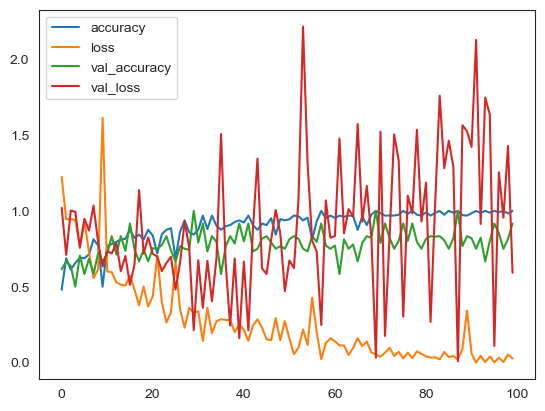

In [204]:
history_df.plot()

In [207]:
test_dir = "/Users/aadityajoshi/Downloads/dataset-2/alien_test"
from tensorflow.keras.preprocessing import image
import numpy as np
import os


# List to store predictions and ground truth labels
predictions = []
ground_truth = []

# Mapping of class indices to weather conditions
class_mapping = {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Shine', 4: 'Sunrise'}

# Iterate through each image in the test directory
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make predictions
    prediction = VGG.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Store predictions and ground truth labels
    predictions.append(class_mapping[predicted_class])
    ground_truth.append(filename.split('_')[0].capitalize())  # Extract the ground truth from the filename

# Display the predictions and ground truth
for i in range(len(predictions)):
    print(f"Image: {os.listdir(test_dir)[i]}, Predicted: {predictions[i]}, Ground Truth: {ground_truth[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

#### Calculate accuracy:
Accuracy = (Number of correct predictions) / (Total number of images)
Accuracy = 21 / 30 = 0.70

To express this as a percentage:
0.70 * 100 = 70%
Therefore, the accuracy of the predictions is approximately 73.33%.
Here's a breakdown of the performance for each class:

Rain/Rainy: 6/6 correct (100% accuracy)
Sunrise: 7/7 correct (100% accuracy)
Shine: 3/3 correct (100% accuracy)
Foggy: 4/10 correct (40% accuracy)
Cloud: 1/5 correct (20% accuracy)
#model struggles with cloud and foggy weather

### MobileNet Architechture

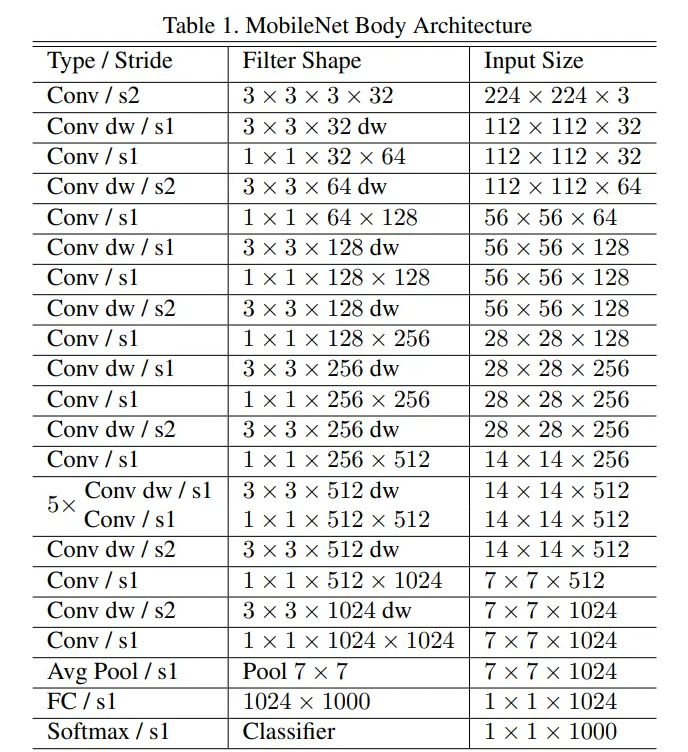

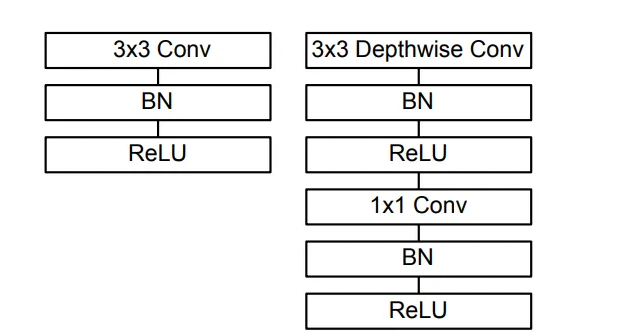

### Implementing MobileNet

In [191]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,ReLU,Conv2D,DepthwiseConv2D,Input,GlobalAveragePooling2D
#importing Activation for RElu

### There are 2 types of Convolution blocks in MobileNet
### 1. Normal Conv --- Conv -> BatchNorm -> ReLU
### 2. Depthwise Conv --- Depthwise_Conv -> BathchNorm -> ReLU

### We've used Sequential API which is more verbose but easier to understand

In [192]:
def create_MobileNet():
    # Create Sequential Model
    model = Sequential()
    # Input Layer
    model.add(Input(shape=(224,224,3)))
    # 1st Normal Conv
    model.add(Conv2D(filters=32,kernel_size=3,strides=(2,2),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 1st DepthWiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(1,1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=32,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 2nd Normal Conv
    model.add(Conv2D(kernel_size=1,filters=64,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 2nd DepthwiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(2,2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=64,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 3rd Normal Conv
    model.add(Conv2D(kernel_size=1,filters=128,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 3rd DepthwiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(1,1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=128,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 4th Normal Conv
    model.add(Conv2D(kernel_size=1,filters=128,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 4th DepthwiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(2,2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=128,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 5th Normal Conv
    model.add(Conv2D(kernel_size=1,filters=256,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 5th DepthwiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(1,1)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=256,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 6th Normal Conv
    model.add(Conv2D(kernel_size=1,filters=256,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 6th DepthwiseConv
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(2,2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=256,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 7th Normal Conv
    model.add(Conv2D(kernel_size=1,filters=512,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    # 5x in dw + normalconv
    for i in range(5):
        model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(1,1)))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Conv2D(kernel_size=1,strides=(1,1),filters=512,padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
        # Normal Conv
        model.add(Conv2D(kernel_size=1,filters=512,strides=(1,1),padding='same'))
        model.add(BatchNormalization())
        model.add(ReLU())
    #depthwiseConv s2
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(2,2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=512,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #Nomral conv
    model.add(Conv2D(kernel_size=1,filters=1024,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #depth wise s2
    model.add(DepthwiseConv2D(kernel_size=3,padding='same',strides=(2,2)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(kernel_size=1,strides=(1,1),filters=1024,padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #normal conv
    model.add(Conv2D(kernel_size=1,filters=1024,strides=(1,1),padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    #AVg pool
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    #FC layer
    model.add(Dense(1000,activation='relu'))
    #output layer 5
    model.add(Dense(5,activation='softmax'))
    
    #compiling model
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    #summary
    model.summary()
    #return model
    return model

In [208]:
from tensorflow.keras.backend import clear_session
clear_session()
MobileNet = create_MobileNet()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 112, 112, 32)   │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 56, 56, 64)     │           640 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 7,085,013 (27.03 MB)

 Trainable params: 7,053,205 (26.91 MB)

 Non-trainable params: 31,808 (124.25 KB)

In [211]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):    
    history = MobileNet.fit(train_generator,
                validation_data=val_generator,
                steps_per_epoch=train_generator.samples//train_generator.batch_size,
                validation_steps= val_generator.samples//val_generator.batch_size,
               epochs =50)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 542ms/step - accuracy: 0.7658 - loss: 0.6987 - val_accuracy: 0.4931 - val_loss: 1.8708
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9375 - loss: 0.4302 - val_accuracy: 0.7500 - val_loss: 1.4761
Epoch 3/50


2024-07-28 16:38:43.739961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:38:43.739993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_100/_572]]
2024-07-28 16:38:43.740027: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:38:43.740063: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:38:43.740068: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:38:43.740071: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 118671

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 540ms/step - accuracy: 0.7740 - loss: 0.6850 - val_accuracy: 0.4062 - val_loss: 2.0329
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.5430 - val_accuracy: 0.2500 - val_loss: 3.7706
Epoch 5/50


2024-07-28 16:39:04.917666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:39:04.917791: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:39:04.917797: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:39:04.917800: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4686261819294484788
2024-07-28 16:39:04.917802: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14506474824354794164
2024-07-28 16:39:04.917804: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5502508477259057974
2024-07-28 16:39:04.917806: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 507ms/step - accuracy: 0.7343 - loss: 0.7361 - val_accuracy: 0.4167 - val_loss: 1.7335
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.8573 - val_accuracy: 0.5833 - val_loss: 1.5577
Epoch 7/50


2024-07-28 16:39:24.981963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:39:24.981999: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13926416179717501202
2024-07-28 16:39:24.982002: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 8107165737012781386
2024-07-28 16:39:24.982005: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:39:24.982013: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6337623219378663100
2024-07-28 16:39:24.982021: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:39:24.982024: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 501ms/step - accuracy: 0.7244 - loss: 0.7743 - val_accuracy: 0.5417 - val_loss: 1.9841
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.7266 - val_accuracy: 0.6667 - val_loss: 1.8211
Epoch 9/50


2024-07-28 16:39:44.747691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:39:44.747728: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:39:44.747738: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11003809716518601478
2024-07-28 16:39:44.747741: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1743676788654130378
2024-07-28 16:39:44.747748: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:39:44.747756: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4686261819294484788
2024-07-28 16:39:44.747760: W tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.7456 - loss: 0.7673 - val_accuracy: 0.3194 - val_loss: 2.9150
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.9573 - val_accuracy: 0.4167 - val_loss: 2.6712
Epoch 11/50


2024-07-28 16:40:05.231087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:40:05.231121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_100/_572]]
2024-07-28 16:40:05.231138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1637042138158107406
2024-07-28 16:40:05.231152: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:40:05.231172: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15746403764630291535
2024-07-28 16:40:05.231182: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 144841

37/37 ━━━━━━━━━━━━━━━━━━━━ 27s 703ms/step - accuracy: 0.7282 - loss: 0.7529 - val_accuracy: 0.3681 - val_loss: 2.5695
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.7133 - val_accuracy: 0.4167 - val_loss: 2.8549
Epoch 13/50


2024-07-28 16:40:32.555063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:40:32.555092: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4686261819294484788
2024-07-28 16:40:32.555095: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14506474824354794164
2024-07-28 16:40:32.555098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5502508477259057974
2024-07-28 16:40:32.555154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/ArgMax/_670]]
2024-07-28 16:40:32.555169: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2456394034231

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.7147 - loss: 0.7685 - val_accuracy: 0.3750 - val_loss: 2.9700
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - loss: 1.0526 - val_accuracy: 0.5000 - val_loss: 2.2551
Epoch 15/50


2024-07-28 16:40:52.851318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:40:52.851352: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18084102248074652630
2024-07-28 16:40:52.851363: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:40:52.851374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/ArgMax/_670]]
2024-07-28 16:40:52.851377: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17420109819586326122
2024-07-28 16:40:52.851380: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 44237784038

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 544ms/step - accuracy: 0.7241 - loss: 0.7891 - val_accuracy: 0.4653 - val_loss: 2.6929
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.5087 - val_accuracy: 0.7500 - val_loss: 0.9377
Epoch 17/50


2024-07-28 16:41:14.477682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:41:14.477734: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_170/_648]]
2024-07-28 16:41:14.477745: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:41:14.477749: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11003809716518601478
2024-07-28 16:41:14.477770: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:41:14.477778: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 46862

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.7301 - loss: 0.7912 - val_accuracy: 0.3924 - val_loss: 8.8440
Epoch 18/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.6073 - val_accuracy: 0.3333 - val_loss: 6.5166
Epoch 19/50


2024-07-28 16:41:36.221380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:41:36.221420: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:41:36.221460: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_288/_454]]
2024-07-28 16:41:36.221474: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3007108867145652466
2024-07-28 16:41:36.221477: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 18084102248074652630
2024-07-28 16:41:36.221480: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 163704

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 540ms/step - accuracy: 0.7768 - loss: 0.6419 - val_accuracy: 0.5312 - val_loss: 2.5788
Epoch 20/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7812 - loss: 0.7489 - val_accuracy: 0.5000 - val_loss: 3.0128
Epoch 21/50


2024-07-28 16:41:57.492052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:41:57.492162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_100/_572]]
2024-07-28 16:41:57.492191: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:41:57.492215: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:41:57.492219: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:41:57.492226: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 118671

37/37 ━━━━━━━━━━━━━━━━━━━━ 23s 580ms/step - accuracy: 0.7701 - loss: 0.6832 - val_accuracy: 0.3576 - val_loss: 2.6710
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.5401 - val_accuracy: 0.2500 - val_loss: 3.2372
Epoch 23/50


2024-07-28 16:42:20.743686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:42:20.743714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:42:20.743717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:42:20.743721: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:42:20.743724: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4686261819294484788
2024-07-28 16:42:20.743726: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5502508477259057974
2024-07-28 16:42:20.743731: I tensorflow/core/framework/local_rendezv

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 557ms/step - accuracy: 0.7280 - loss: 0.7541 - val_accuracy: 0.3993 - val_loss: 2.5031
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8750 - loss: 0.3479 - val_accuracy: 0.7500 - val_loss: 1.1104
Epoch 25/50


2024-07-28 16:42:42.594471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:42:42.594504: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4644167230371615172
2024-07-28 16:42:42.594507: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:42:42.594512: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:42:42.594522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_100/_572]]
2024-07-28 16:42:42.594537: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1186712

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - accuracy: 0.7676 - loss: 0.6315 - val_accuracy: 0.2847 - val_loss: 5.4415
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.8296 - val_accuracy: 0.1667 - val_loss: 6.7456
Epoch 27/50


2024-07-28 16:43:02.819909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:43:02.819938: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9856948146824458738
2024-07-28 16:43:02.819953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_144/_620]]
2024-07-28 16:43:02.819982: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15326159123654088482
2024-07-28 16:43:02.819990: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15687405767216361970
2024-07-28 16:43:02.820008: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 145064

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.7290 - loss: 0.7385 - val_accuracy: 0.5764 - val_loss: 1.7877
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6875 - loss: 0.8593 - val_accuracy: 0.2500 - val_loss: 2.8252
Epoch 29/50


2024-07-28 16:43:22.710663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:43:22.710702: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:43:22.710710: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:43:22.710714: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:43:22.710717: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4686261819294484788
2024-07-28 16:43:22.710720: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5502508477259057974
2024-07-28 16:43:22.710723: I tensorflow/core/framework/local_rendezv

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 509ms/step - accuracy: 0.7631 - loss: 0.6720 - val_accuracy: 0.5139 - val_loss: 1.9759
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7812 - loss: 0.7554 - val_accuracy: 0.5000 - val_loss: 2.5461
Epoch 31/50


2024-07-28 16:43:42.692406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:43:42.692453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_100/_572]]
2024-07-28 16:43:42.692467: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:43:42.692470: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3812768221398517450
2024-07-28 16:43:42.692473: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:43:42.692476: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 468626

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.7224 - loss: 0.7487 - val_accuracy: 0.4236 - val_loss: 2.3281
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.5800 - val_accuracy: 0.1667 - val_loss: 3.0257
Epoch 33/50


2024-07-28 16:44:03.121180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:44:03.121219: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1637042138158107406
2024-07-28 16:44:03.121252: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:44:03.121286: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4521887091262993456
2024-07-28 16:44:03.121296: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:44:03.121302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5502508477259057974
2024-07-28 16:44:03.121318: W tensorflow/core/framework/local_rendezvo

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 512ms/step - accuracy: 0.7530 - loss: 0.6649 - val_accuracy: 0.3160 - val_loss: 3.5274
Epoch 34/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8438 - loss: 0.5537 - val_accuracy: 0.3333 - val_loss: 3.0666
Epoch 35/50


2024-07-28 16:44:23.519682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:44:23.519720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_194/_348]]
2024-07-28 16:44:23.519754: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6435273736968478527
2024-07-28 16:44:23.519762: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5777721722671078427
2024-07-28 16:44:23.519777: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:44:23.519786: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1100380

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 513ms/step - accuracy: 0.8065 - loss: 0.6081 - val_accuracy: 0.2812 - val_loss: 3.2229
Epoch 36/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6562 - loss: 0.8074 - val_accuracy: 0.0833 - val_loss: 3.0423
Epoch 37/50


2024-07-28 16:44:43.951582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:44:43.951616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_114/_586]]
2024-07-28 16:44:43.951634: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17131980713943202684
2024-07-28 16:44:43.951640: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6435273736968478527
2024-07-28 16:44:43.951642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13636472268339777813
2024-07-28 16:44:43.951645: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 144981

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 545ms/step - accuracy: 0.7285 - loss: 0.7416 - val_accuracy: 0.3368 - val_loss: 5.8280
Epoch 38/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6875 - loss: 0.7347 - val_accuracy: 0.4167 - val_loss: 6.3808
Epoch 39/50


2024-07-28 16:45:06.138501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:45:06.138544: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10102383329106313494
2024-07-28 16:45:06.138556: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:45:06.138560: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1743676788654130378
2024-07-28 16:45:06.138564: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:45:06.138567: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17937401700667501642
2024-07-28 16:45:06.138579: I tensorflow/core/framework/local_rende

37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 537ms/step - accuracy: 0.7898 - loss: 0.6227 - val_accuracy: 0.2500 - val_loss: 6.6504
Epoch 40/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.7503 - val_accuracy: 0.2500 - val_loss: 5.6064
Epoch 41/50


2024-07-28 16:45:28.187212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:45:28.187241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_256/_418]]
2024-07-28 16:45:28.187255: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13929462958089896078
2024-07-28 16:45:28.187266: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13220492393268904350
2024-07-28 16:45:28.187278: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7272447004238676646
2024-07-28 16:45:28.187292: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 170440

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7617 - loss: 0.6835 - val_accuracy: 0.4236 - val_loss: 3.1072
Epoch 42/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7500 - loss: 0.6327 - val_accuracy: 0.4167 - val_loss: 2.4555
Epoch 43/50


2024-07-28 16:45:48.489274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:45:48.489313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 9856948146824458738
2024-07-28 16:45:48.489316: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:45:48.489327: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11003809716518601478
2024-07-28 16:45:48.489330: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15326159123654088482
2024-07-28 16:45:48.489333: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:45:48.489336: I tensorflow/core/framework/local_rende

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 520ms/step - accuracy: 0.8112 - loss: 0.5596 - val_accuracy: 0.4514 - val_loss: 3.7949
Epoch 44/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8125 - loss: 0.5122 - val_accuracy: 0.4167 - val_loss: 3.4535
Epoch 45/50


2024-07-28 16:46:09.203302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:46:09.203338: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13926416179717501202
2024-07-28 16:46:09.203372: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:46:09.203395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_114/_586]]
2024-07-28 16:46:09.203413: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6435273736968478527
2024-07-28 16:46:09.203418: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 452188

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.7813 - loss: 0.6480 - val_accuracy: 0.4340 - val_loss: 2.2394
Epoch 46/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6875 - loss: 0.6819 - val_accuracy: 0.4167 - val_loss: 1.8340
Epoch 47/50


2024-07-28 16:46:30.011057: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:46:30.011122: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12900633395908043934
2024-07-28 16:46:30.011127: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:46:30.011130: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:46:30.011133: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11867126289509009152
2024-07-28 16:46:30.011136: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1637042138158107406
2024-07-28 16:46:30.011140: I tensorflow/core/framework/local_rendez

37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 495ms/step - accuracy: 0.7397 - loss: 0.7471 - val_accuracy: 0.4931 - val_loss: 1.5886
Epoch 48/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.3279 - val_accuracy: 0.5833 - val_loss: 1.7692
Epoch 49/50


2024-07-28 16:46:49.696585: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:46:49.696627: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13430735567052751572
2024-07-28 16:46:49.696638: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14030013915417732436
2024-07-28 16:46:49.696642: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 1442689975801931564
2024-07-28 16:46:49.696645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_126/_600]]
2024-07-28 16:46:49.696697: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 468626

37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 500ms/step - accuracy: 0.8054 - loss: 0.5995 - val_accuracy: 0.6562 - val_loss: 1.2039
Epoch 50/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7188 - loss: 0.9910 - val_accuracy: 0.7500 - val_loss: 1.1109


2024-07-28 16:47:10.164107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-28 16:47:10.164138: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13926416179717501202
2024-07-28 16:47:10.164170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/add_114/_586]]
2024-07-28 16:47:10.164198: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 17420109819586326122
2024-07-28 16:47:10.164221: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4521887091262993456
2024-07-28 16:47:10.164224: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 505524

In [213]:
test_dir = "/Users/aadityajoshi/Downloads/dataset-2/alien_test"
from tensorflow.keras.preprocessing import image
import numpy as np
import os


# List to store predictions and ground truth labels
predictions = []
ground_truth = []

# Mapping of class indices to weather conditions
class_mapping = {0: 'Cloudy', 1: 'Foggy', 2: 'Rainy', 3: 'Shine', 4: 'Sunrise'}

# Iterate through each image in the test directory
for filename in os.listdir(test_dir):
    img_path = os.path.join(test_dir, filename)
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize the image

    # Make predictions
    prediction = MobileNet.predict(img_array)
    predicted_class = np.argmax(prediction)

    # Store predictions and ground truth labels
    predictions.append(class_mapping[predicted_class])
    ground_truth.append(filename.split('_')[0].capitalize())  # Extract the ground truth from the filename

# Display the predictions and ground truth
for i in range(len(predictions)):
    print(f"Image: {os.listdir(test_dir)[i]}, Predicted: {predictions[i]}, Ground Truth: {ground_truth[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [215]:
MobileNet.save("weather_model.keras")

In [219]:
from tensorflow.keras.models import load_model

In [222]:
MobileNet = load_model('/Users/aadityajoshi/Downloads/MobileNet300_Weather_Model.keras')

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 224, 224, 3], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_1'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_1', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_2', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_3', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_1', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 64]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_4', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_4', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_3', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_5', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_5', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_4', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 64]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_6', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_6', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_2', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_7', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_7', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_5', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_8', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_8', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_6', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_9', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_9', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_3', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 56, 56, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_10', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_10', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_7', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_11', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_11', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_8', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 128]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_12', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_12', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_4', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_13', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_13', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_9', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_14', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_14', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_10', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_15', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_15', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_5', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 28, 28, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_16', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_16', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': 'float32', 'filters': 256, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_17', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_17', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 256]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_18', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_18', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_6', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_19', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_19', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_13', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_20', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_20', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_14', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_21', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_21', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_7', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_22', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_22', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_15', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_23', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_23', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_16', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_24', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_24', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_8', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_25', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_25', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_17', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_26', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_26', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_18', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_27', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_27', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_9', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_28', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_28', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_19', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_29', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_29', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_20', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_30', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_30', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_10', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_31', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_31', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_21', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_32', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_32', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_22', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_33', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_33', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_11', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 14, 14, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_34', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_34', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_23', 'trainable': True, 'dtype': 'float32', 'filters': 512, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_35', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_35', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_24', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 512]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_36', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_36', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}}, {'module': 'keras.layers', 'class_name': 'DepthwiseConv2D', 'config': {'name': 'depthwise_conv2d_12', 'trainable': True, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [2, 2], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 7, 7, 1024]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_37', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_37', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_25', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_38', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_38', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_26', 'trainable': True, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [1, 1], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_39', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'ReLU', 'config': {'name': 're_lu_39', 'trainable': True, 'dtype': 'float32', 'max_value': None, 'negative_slope': 0.0, 'threshold': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 4, 1024]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 1000, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1024]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 5, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 1000]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 224, 224, 3]}, 'compile_config': {'optimizer': 'adam', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}.

Exception encountered: <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 112, 112, 32]}}.

Exception encountered: Error when deserializing class 'BatchNormalization' using config={'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': [3], 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}.

Exception encountered: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [226]:
import os
import json
import h5py
import tensorflow as tf

def inspect_and_convert_model(file_path):
    _, file_extension = os.path.splitext(file_path)
    
    if file_extension == '.keras':
        try:
            # Try loading as a SavedModel
            model = tf.keras.models.load_model(file_path)
            print("Successfully loaded as a SavedModel.")
            return model.to_json()
        except:
            try:
                # Try loading as an HDF5 file
                with h5py.File(file_path, 'r') as f:
                    model_config = f.attrs.get('model_config')
                    if model_config is not None:
                        print("Successfully loaded as an HDF5 file.")
                        return model_config.decode('utf-8')
                    else:
                        print("File is in HDF5 format but doesn't contain model config.")
            except:
                print("Unable to load as SavedModel or HDF5.")
    elif file_extension in ['.h5', '.hdf5']:
        try:
            # Try loading as an HDF5 file
            with h5py.File(file_path, 'r') as f:
                model_config = f.attrs.get('model_config')
                if model_config is not None:
                    print("Successfully loaded as an HDF5 file.")
                    return model_config.decode('utf-8')
                else:
                    print("File is in HDF5 format but doesn't contain model config.")
        except:
            print("Unable to load as HDF5.")
    else:
        print(f"Unsupported file format: {file_extension}")
    
    return None

# Use the function
model_file_path = '/Users/aadityajoshi/Downloads/MobileNet300_Weather_Model.keras'
try:
    model_json = inspect_and_convert_model(model_file_path)
    if model_json:
        # Save the model architecture to a JSON file
        with open('model_architecture.json', 'w') as json_file:
            json_file.write(model_json)
        print("Model architecture has been saved to 'model_architecture.json'")
    else:
        print("Unable to extract model architecture.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Unable to load as SavedModel or HDF5.
Unable to extract model architecture.


In [230]:
import os
import json
from tensorflow.python.lib.io import file_io
from tensorflow.python.framework import tensor_util

def extract_saved_model_config(saved_model_dir):
    # Path to the saved_model.pb file
    saved_model_pb_path = os.path.join(saved_model_dir, 'saved_model.pb')
    
    if not file_io.file_exists(saved_model_pb_path):
        print(f"saved_model.pb not found in {saved_model_dir}")
        return None
    
    # Read the contents of saved_model.pb
    with file_io.FileIO(saved_model_pb_path, 'rb') as f:
        saved_model_pb = f.read()
    
    # Path to the assets directory
    assets_dir = os.path.join(saved_model_dir, 'assets')
    
    # Check if keras_metadata.pb exists in the assets directory
    keras_metadata_path = os.path.join(assets_dir, 'keras_metadata.pb')
    if file_io.file_exists(keras_metadata_path):
        with file_io.FileIO(keras_metadata_path, 'rb') as f:
            keras_metadata = f.read()
        print("keras_metadata.pb found and read")
    else:
        print("keras_metadata.pb not found")
    
    # Try to find and read a JSON configuration file
    json_files = [f for f in file_io.list_directory(saved_model_dir) if f.endswith('.json')]
    if json_files:
        json_path = os.path.join(saved_model_dir, json_files[0])
        with file_io.FileIO(json_path, 'r') as f:
            json_config = json.load(f)
        print(f"JSON configuration found: {json_files[0]}")
        return json_config
    else:
        print("No JSON configuration file found")
    
    return None

# Use the function
saved_model_dir = '/Users/aadityajoshi/Downloads/MobileNet300_Weather_Model.keras'
config = extract_saved_model_config(saved_model_dir)

if config:
    with open('model_config.json', 'w') as f:
        json.dump(config, f, indent=2)
    print("Model configuration has been saved to 'model_config.json'")
else:
    print("Unable to extract model configuration")

saved_model.pb not found in /Users/aadityajoshi/Downloads/MobileNet300_Weather_Model.keras
Unable to extract model configuration


In [228]:
!pip install tensorflow==2.15.0

  Obtaining dependency information for tensorflow==2.15.0 from https://files.pythonhosted.org/packages/85/15/cf99a373812d37f8ae99752a34a9f5f690d820ceb5b302e922705bc18944/tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl.metadata (3.6 kB)
  Obtaining dependency information for ml-dtypes~=0.2.0 from https://files.pythonhosted.org/packages/15/da/43bee505963da0c730ee50e951c604bfdb90d4cccc9c0044c946b10e68a7/ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata
  Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Obtaining dependency information for tensorboard<2.16,>=2.15 from https://files.pythonhosted.org/packages/37/12/f6e9b9dcc310263cbd3948274e286538bd6800fd0c268850788f14a0c6d0/tensorboard-2.15.2-py3-none-any.whl.metadata
  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Obtaining dependency information for keras<2.16,>=2.15.0 from https://file

Using cached tensorflow-2.15.0-cp311-cp311-macosx_12_0_arm64.whl (2.1 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
Using cached ml_dtypes-0.2.0-cp311-cp311-macosx_10_9_universal2.whl (1.2 MB)
Using cached tensorboard-2.15.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1


In [231]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Flatten, Dense
import json

def create_MobileNet(input_shape=(224, 224, 3), num_classes=5):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=3, strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # ... (rest of the model definition as provided in your code)
    
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(1000, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

def modify_model(model, modifications):
    """
    Modify the model based on the provided modifications.
    modifications is a dictionary where keys are layer indices and values are new configurations.
    """
    config = model.get_config()
    layers = config['layers']
    
    for index, new_config in modifications.items():
        layers[index].update(new_config)
    
    new_model = tf.keras.models.model_from_config(config)
    return new_model

# Create the original model
original_model = create_MobileNet()

# Example modifications (you can adjust these as needed)
modifications = {
    1: {'config': {'filters': 64}},  # Change the first Conv2D layer to have 64 filters
    -2: {'config': {'units': 512}}   # Change the penultimate Dense layer to have 512 units
}

# Apply modifications
modified_model = modify_model(original_model, modifications)

# Save the modified model architecture as JSON
model_json = modified_model.to_json()
with open('modified_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("Modified model architecture has been saved to 'modified_model_architecture.json'")

# Print summary of the modified model
modified_model.summary()

AttributeError: module 'tensorflow.keras.models' has no attribute 'model_from_config'

In [232]:
def modify_model(model, modifications):
    """
    Modify the model based on the provided modifications.
    modifications is a dictionary where keys are layer indices and values are new configurations.
    """
    config = model.get_config()
    layers = config['layers']
    
    for index, new_config in modifications.items():
        layers[index]['config'].update(new_config['config'])
    
    new_model = Sequential.from_config(config)
    return new_model

# Create the original model
original_model = create_MobileNet()

# Example modifications (you can adjust these as needed)
modifications = {
    1: {'config': {'filters': 64}},  # Change the first Conv2D layer to have 64 filters
    -2: {'config': {'units': 512}}   # Change the penultimate Dense layer to have 512 units
}

# Apply modifications
modified_model = modify_model(original_model, modifications)

# Save the modified model architecture as JSON
model_json = modified_model.to_json()
with open('modified_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("Modified model architecture has been saved to 'modified_model_architecture.json'")

# Print summary of the modified model
modified_model.summary()

ValueError: Input 0 of layer "batch_normalization_1" is incompatible with the layer: expected axis -1 of input shape to have value 32, but received input with shape (None, 112, 112, 64)